In [1]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [3]:
## Build xarray-simlab model ##
SouthernAndesLEM = precip_model
SouthernAndesLEM = precip_model.drop_processes(['init_topography'])
SouthernAndesLEM = SouthernAndesLEM.update_processes({'bedrock': Bedrock})

SouthernAndesLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallout time
    nm                     [in] moist stability frequency
    hw  

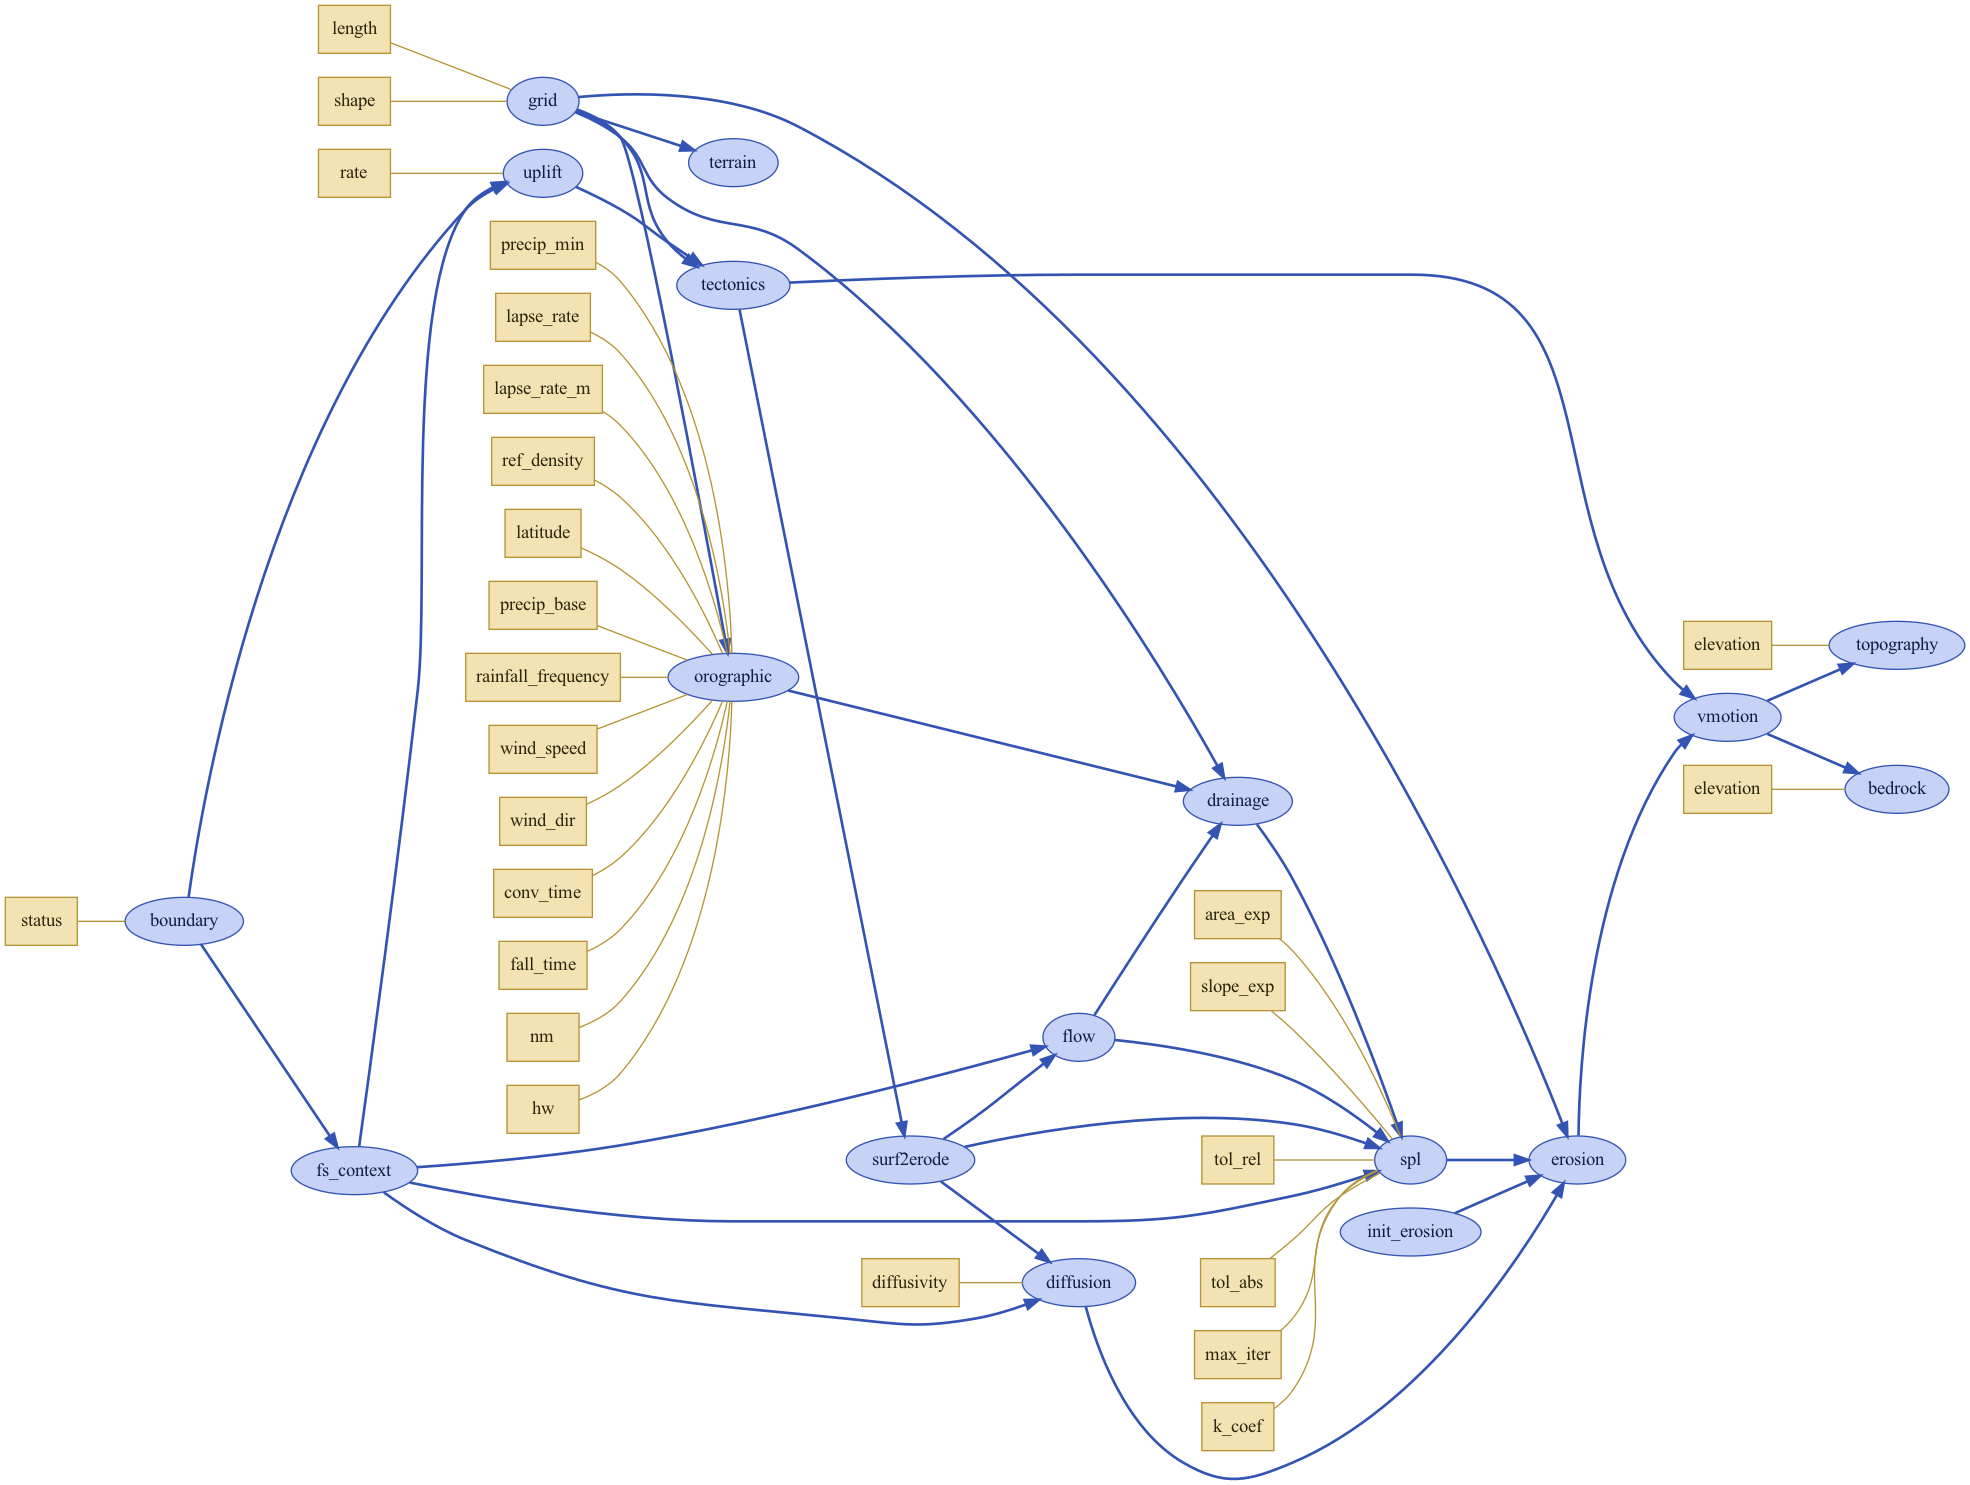

In [4]:
## Visualise xarray-simlab ##
SouthernAndesLEM.visualize(show_inputs='True')

In [5]:
## Model dimensions/grid dimensions ##
nx = 100
ny = 100
nn = nx * ny

xl = 100.e3
yl = 100.e3

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.


## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left default
ref_density = 7.4e-3  #left default
rainfall_frequency = 5 #could not find high resolution data for hourly rainfall in the area of patagonia i was interested in looking at so just an estimate
latitude = -50  #latitude around the area north in the Patagonian Andes
precip_base =  2 #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 230  # estimated direction given weather info 
precip_min = 0.1 #default
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 5000  #default


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 42

In [6]:
import os
import numpy as np
import xarray as xr
import xsimlab as xs

# Load downscaled elevation and uplift rate from NetCDF
dem_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_demnew.nc'
uplift_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_upliftnew.nc'

dem_ds = xr.open_dataset(dem_output)
uplift_ds = xr.open_dataset(uplift_output)

# Extract variables
initial_topography = dem_ds["elevation"].values  # Shape should match [nx, ny]
uplift_rate = uplift_ds["uplift_rate"].values  # Shape should match [nx, ny]

# Ensure shapes match the model grid (adjust if necessary)
nx, ny = initial_topography.shape  # Get dimensions from DEM

# Directory to save Zarr files
output_dir = "simulation_outputs"
os.makedirs(output_dir, exist_ok=True)

# Define rainfall_frequency values to test
rainfall_frequency_values = np.linspace(0.1, 24, 10)  # Example range from 0.1 to 2.0

# Time steps to visualize
time_indices = [0, 1, 10, 100, 1000, 10000]
mean_elevations = []

# Loop through rainfall_frequency values and run simulations
for rainfall_frequency in rainfall_frequency_values:
    print(f"Running simulation for rainfall_frequency = {rainfall_frequency}")
    
    # Set up the model with the current rainfall_frequency
    in_ds_rain = xs.create_setup(
        model=SouthernAndesLEM,
        clocks={
            'time': ModelTime_1,
            'output': ModelTime_1[::PlotStep]
        },
        master_clock='time',
        input_vars={
            'grid': {'shape': [nx, ny], 'length': [xl, yl]},
            'boundary': {'status': BoundaryCondition},
            'topography': {'elevation': initial_topography},
            'bedrock': {'elevation': initial_topography},
            'uplift': {'rate': uplift_rate},
            'spl': {'k_coef': k_coef, 'area_exp': area_exp, 'slope_exp': slope_exp},
            'diffusion': {'diffusivity': diffusion_diffusivity},
            'orographic': {
                'lapse_rate': lapse_rate,
                'lapse_rate_m': lapse_rate_m,
                'ref_density': ref_density,
                'rainfall_frequency': rainfall_frequency,  # Change rainfall_frequency
                'latitude': latitude,
                'precip_base': precip_base,
                'wind_speed': wind_speed,
                'wind_dir': wind_dir,
                'precip_min': precip_min,
                'conv_time': conv_time,
                'fall_time': fall_time,
                'nm': nm,
                'hw': hw,
            },
        },
        output_vars={'topography__elevation': 'time', 'orographic__precip_rate': 'time'}
    )

    # Run the simulation
    with xs.monitoring.ProgressBar():
        out_ds_rain = in_ds_rain.xsimlab.run(model=SouthernAndesLEM)
    
    # Store simulation results in Zarr format
    zarr_filename = os.path.join(output_dir, f"simulation_rainfall_frequency_{rainfall_frequency:.2f}.zarr")
    out_ds_rain.to_zarr(zarr_filename, mode='w')
    print(f"Saved results for rainfall_frequency = {rainfall_frequency} to {zarr_filename}")

Running simulation for rainfall_frequency = 0.1


             0% | initialize 

Saved results for rainfall_frequency = 0.1 to simulation_outputs/simulation_rainfall_frequency_0.10.zarr
Running simulation for rainfall_frequency = 2.7555555555555555


             0% | initialize 

Saved results for rainfall_frequency = 2.7555555555555555 to simulation_outputs/simulation_rainfall_frequency_2.76.zarr
Running simulation for rainfall_frequency = 5.4111111111111105


             0% | initialize 

Saved results for rainfall_frequency = 5.4111111111111105 to simulation_outputs/simulation_rainfall_frequency_5.41.zarr
Running simulation for rainfall_frequency = 8.066666666666666


             0% | initialize 

Saved results for rainfall_frequency = 8.066666666666666 to simulation_outputs/simulation_rainfall_frequency_8.07.zarr
Running simulation for rainfall_frequency = 10.722222222222221


             0% | initialize 

Saved results for rainfall_frequency = 10.722222222222221 to simulation_outputs/simulation_rainfall_frequency_10.72.zarr
Running simulation for rainfall_frequency = 13.377777777777776


             0% | initialize 

Saved results for rainfall_frequency = 13.377777777777776 to simulation_outputs/simulation_rainfall_frequency_13.38.zarr
Running simulation for rainfall_frequency = 16.033333333333335


             0% | initialize 

Saved results for rainfall_frequency = 16.033333333333335 to simulation_outputs/simulation_rainfall_frequency_16.03.zarr
Running simulation for rainfall_frequency = 18.68888888888889


             0% | initialize 

Saved results for rainfall_frequency = 18.68888888888889 to simulation_outputs/simulation_rainfall_frequency_18.69.zarr
Running simulation for rainfall_frequency = 21.344444444444445


             0% | initialize 

Saved results for rainfall_frequency = 21.344444444444445 to simulation_outputs/simulation_rainfall_frequency_21.34.zarr
Running simulation for rainfall_frequency = 24.0


             0% | initialize 

Saved results for rainfall_frequency = 24.0 to simulation_outputs/simulation_rainfall_frequency_24.00.zarr


Available rainfall frequencies in dataset: [ 0.1   2.76  5.41  8.07 10.72 13.38 16.03 18.69 21.34 24.  ]


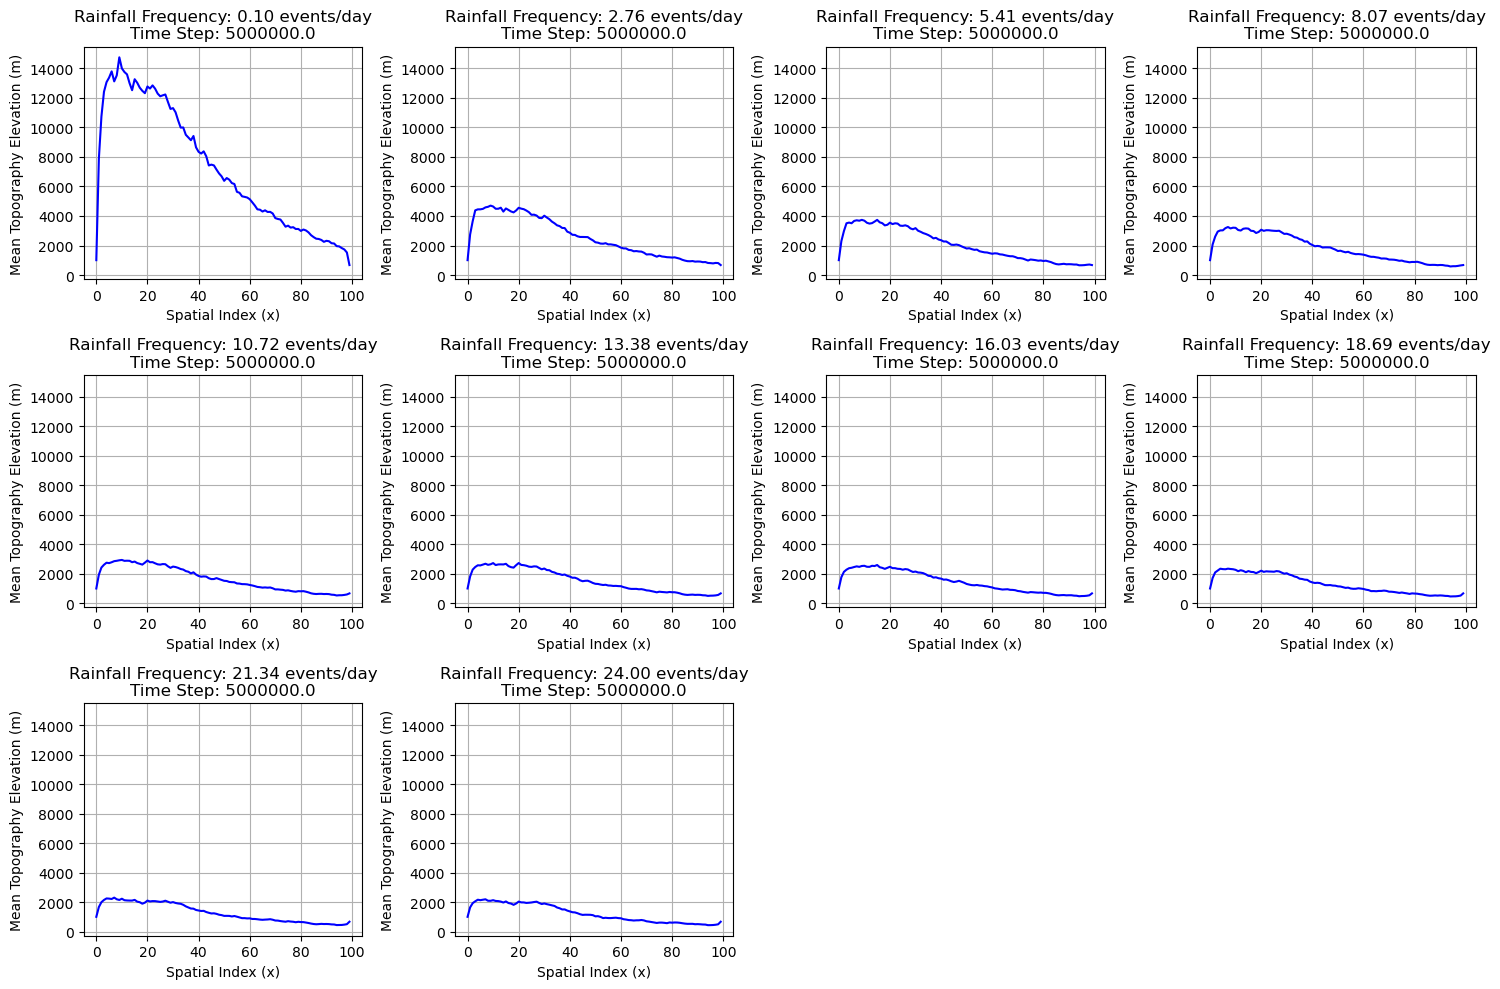

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract and sort rainfall frequency

# Define the rainfall frequency values to plot
desired_rainfall_frequencies = np.linspace(0.1, 24, 10)  # Ensure it matches simulation values

# Load datasets and attach rainfall frequency as a coordinate
datasets = []
rainfall_frequencies = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract rainfall frequency from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    
    # Add rainfall frequency as a coordinate
    ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
    
    datasets.append(ds)
    rainfall_frequencies.append(rainfall_frequency)

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")

# Ensure rainfall_frequency is a dimension and coordinate
combined_ds = combined_ds.sortby("rainfall_frequency")

# Print available values for debugging
print("Available rainfall frequencies in dataset:", combined_ds.rainfall_frequency.values)

# Fix: Use nearest selection for valid rainfall frequencies
valid_rainfall_frequencies = []
for rf in desired_rainfall_frequencies:
    try:
        # Use nearest method to avoid KeyError
        elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(rainfall_frequency=rf, method="nearest").mean(dim='x')
        valid_rainfall_frequencies.append(rf)
    except KeyError:
        print(f"Skipping {rf}: No matching data found.")

# Adjust number of rows and columns based on valid rainfall frequencies
n_valid = len(valid_rainfall_frequencies)
ncols = 4  # Define number of columns
nrows = (n_valid // ncols) + (1 if n_valid % ncols != 0 else 0)  # Calculate rows needed

# Create subplots dynamically based on valid rainfall frequencies
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Initialize variables to track the global min and max for consistent y-axis scaling
global_min_elevation = np.inf
global_max_elevation = -np.inf

# First, loop to find the global min and max of the mean topography elevations
for rf in valid_rainfall_frequencies:
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(rainfall_frequency=rf, method="nearest").mean(dim='x')
    global_min_elevation = min(global_min_elevation, elevation_data.min())
    global_max_elevation = max(global_max_elevation, elevation_data.max())

# Plot only for valid rainfall frequencies
for idx, rf in enumerate(valid_rainfall_frequencies):
    ax = axes[idx]
    time_step = str(combined_ds.time[-1].values)  # Extract the last time step value
    title = f"Rainfall Frequency: {rf:.2f} events/day\nTime Step: {time_step}"
    
    # Get the mean elevation for this rainfall frequency at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(rainfall_frequency=rf, method="nearest").mean(dim='x')
    
    # Plot the elevation data as a line plot
    ax.plot(elevation_data, label='Mean Topography Elevation', color='blue')
    
    # Set title with rainfall frequency and time step info
    ax.set_title(title)
    
    # Set y-axis label
    ax.set_ylabel("Mean Topography Elevation (m)")
    
    # Set x-axis label
    ax.set_xlabel("Spatial Index (x)")
    
    # Calculate 5% padding
    padding = (global_max_elevation - global_min_elevation) * 0.05  
    
    # Apply padding to y-limits
    ax.set_ylim(global_min_elevation - padding, global_max_elevation + padding)
    
    # Add grid for readability
    ax.grid(True)

# Hide unused axes
for ax in axes[len(valid_rainfall_frequencies):]:
    ax.axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


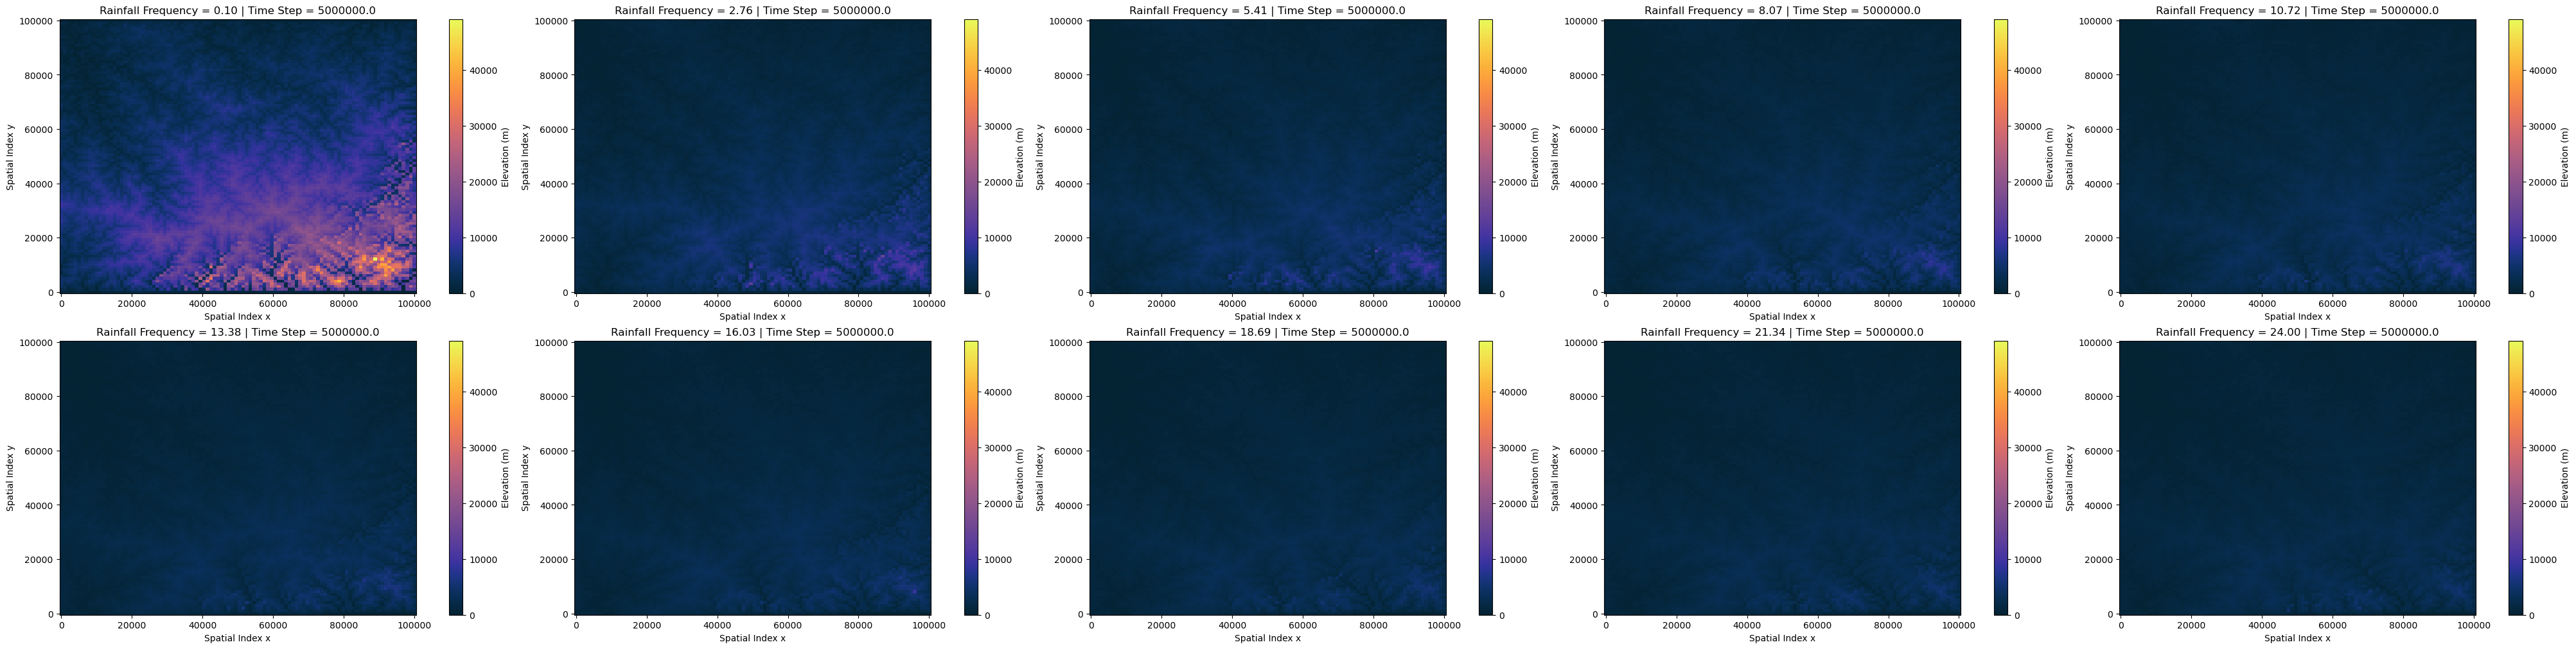

In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean  # Improved colormap
import dask

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency from filename

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies =[0.1, 2.76, 5.41, 8.07, 10.72, 13.38, 16.03, 18.69, 21.34, 24.] # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []
time_steps = []

elevation_min = np.inf  # Track global min
elevation_max = -np.inf  # Track global max

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

        # Update global min/max for consistent scaling
        elevation_min = min(elevation_min, ds.topography__elevation.isel(time=-1).min().values)
        elevation_max = max(elevation_max, ds.topography__elevation.isel(time=-1).max().values)

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(rainfall_frequencies)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Elevation Maps for Selected Rainfall Frequencies at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, rainfall_frequency, time_step in zip(axes, datasets, rainfall_frequencies, time_steps):
    ds.topography__elevation.isel(time=-1).plot(ax=ax,  vmin=elevation_min, vmax=elevation_max, cmap=cmocean.cm.thermal, cbar_kwargs={"label": "Elevation (m)"})
    ax.set_title(f"Rainfall Frequency = {rainfall_frequency:.2f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("Spatial Index x")
    ax.set_ylabel("Spatial Index y")

# Hide any unused subplots
for i in range(len(rainfall_frequencies), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Elevation_RainfallFrequency_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


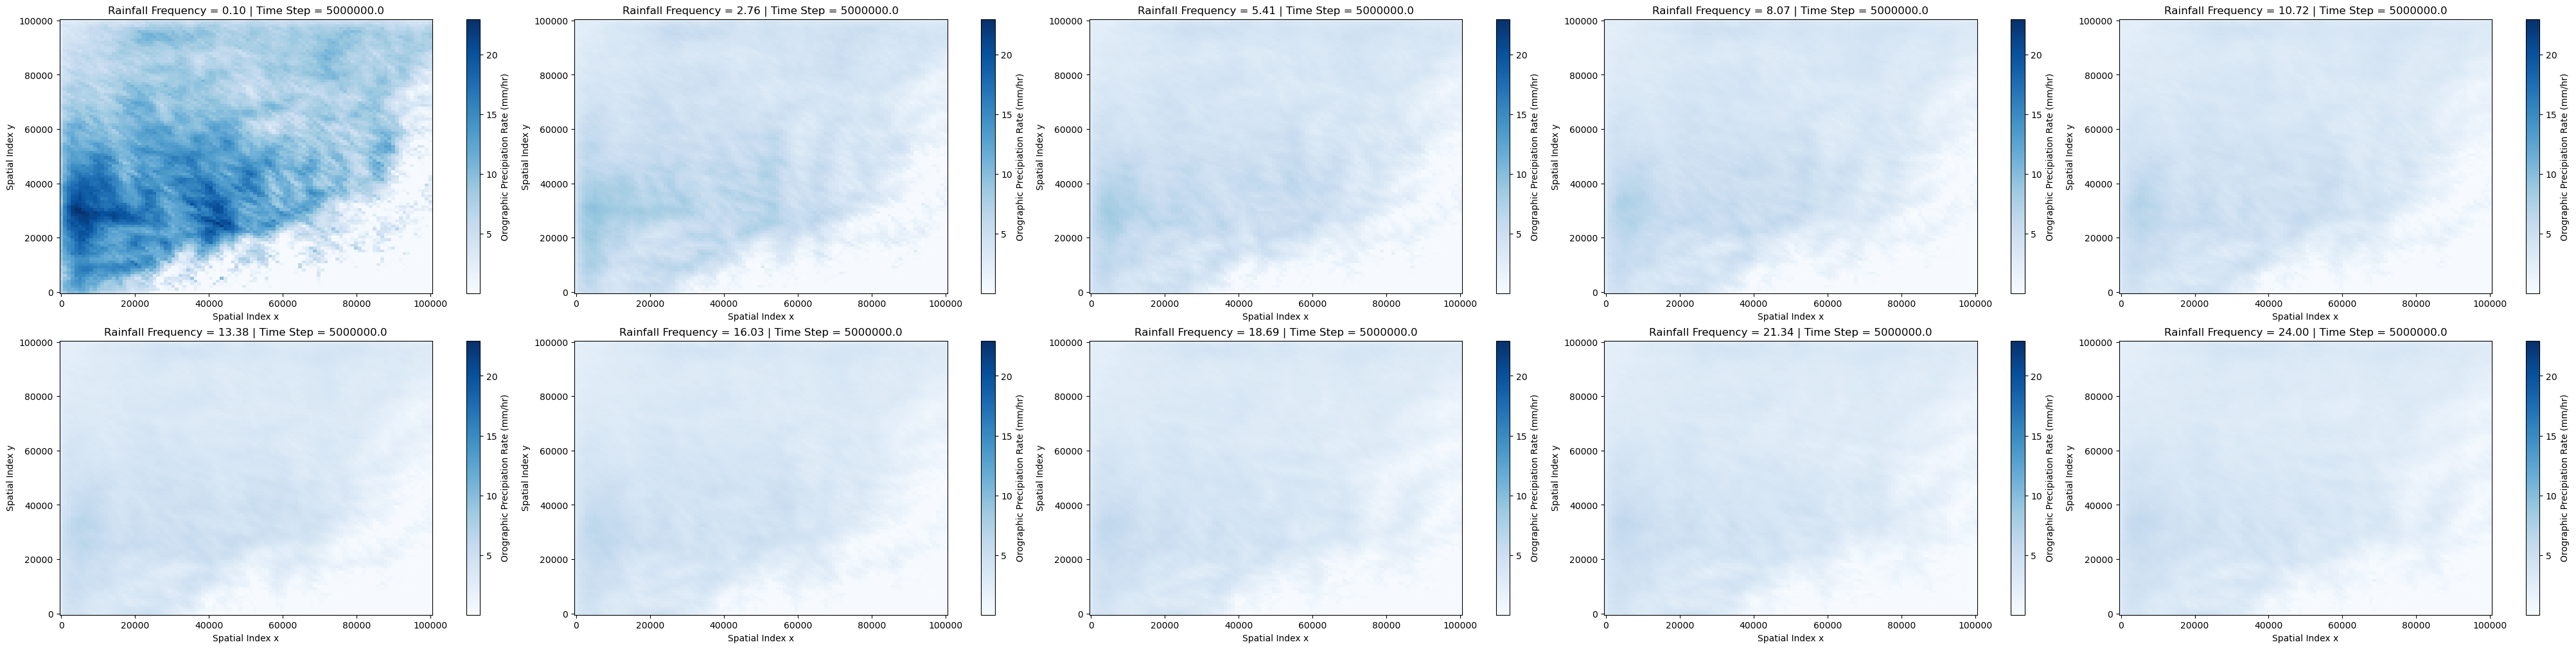

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies = [0.1, 2.76, 5.41, 8.07, 10.72, 13.38, 16.03, 18.69, 21.34, 24.] # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []
time_steps = []

# Initialize global min/max precipitation trackers
precip_min = np.inf
precip_max = -np.inf

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

         # Update global min/max precipitation for consistent scale
        precip = ds.orographic__precip_rate.isel(time=-1)
        precip_min = min(precip_min, precip.min().values)
        precip_max = max(precip_max, precip.max().values)

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(rainfall_frequencies)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Precipitation Maps for Selected Rainfall Frequencies at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, rainfall_frequency, time_step in zip(axes, datasets, rainfall_frequencies, time_steps):
    # Plot precipitation at the final time step
    precip_data = ds.orographic__precip_rate.isel(time=-1)
    precip_data.plot(ax=ax, vmin=precip_min, vmax=precip_max, cmap='Blues',cbar_kwargs={"label": "Orographic Precipiation Rate (mm/hr)"})
    ax.set_title(f"Rainfall Frequency = {rainfall_frequency:.2f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("Spatial Index x")
    ax.set_ylabel("Spatial Index y")

# Hide any unused subplots
for i in range(len(rainfall_frequencies), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Precipitation_RainfallFrequency_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


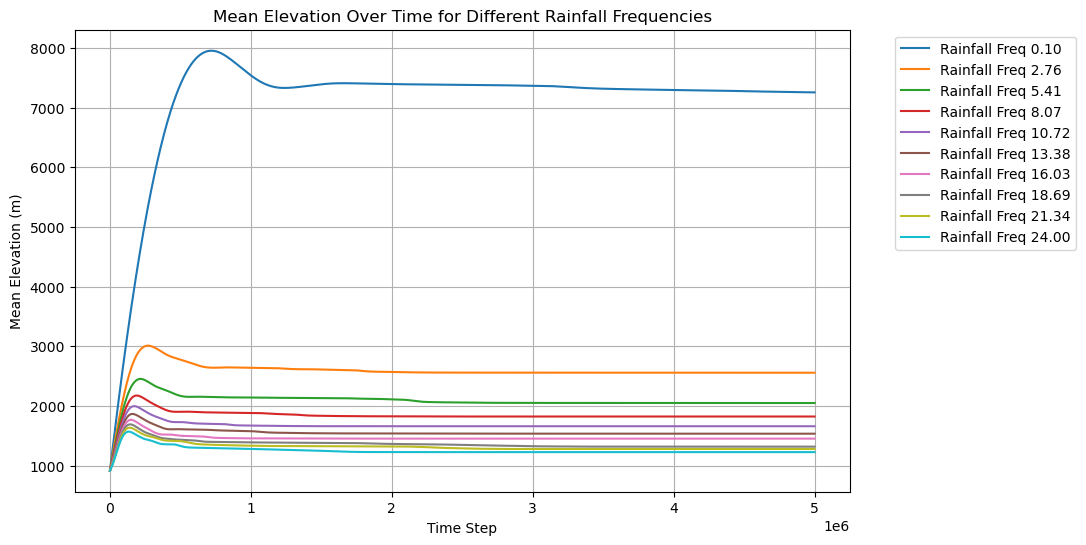

In [26]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies = [0.1, 2.76, 5.41, 8.07, 10.72, 13.38, 16.03, 18.69, 21.34, 24.]  # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

### 📌 Plot 1: Mean Elevation Over Time for Different Rainfall Frequencies
plt.figure(figsize=(10, 6))
for ds, rainfall_frequency in zip(datasets, rainfall_frequencies):
    mean_elevation = ds["topography__elevation"].mean(dim=("x", "y"))
    plt.plot(ds["time"], mean_elevation, label=f"Rainfall Freq {rainfall_frequency:.2f}")

plt.xlabel("Time Step")
plt.ylabel("Mean Elevation (m)")
plt.title("Mean Elevation Over Time for Different Rainfall Frequencies")
# Move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


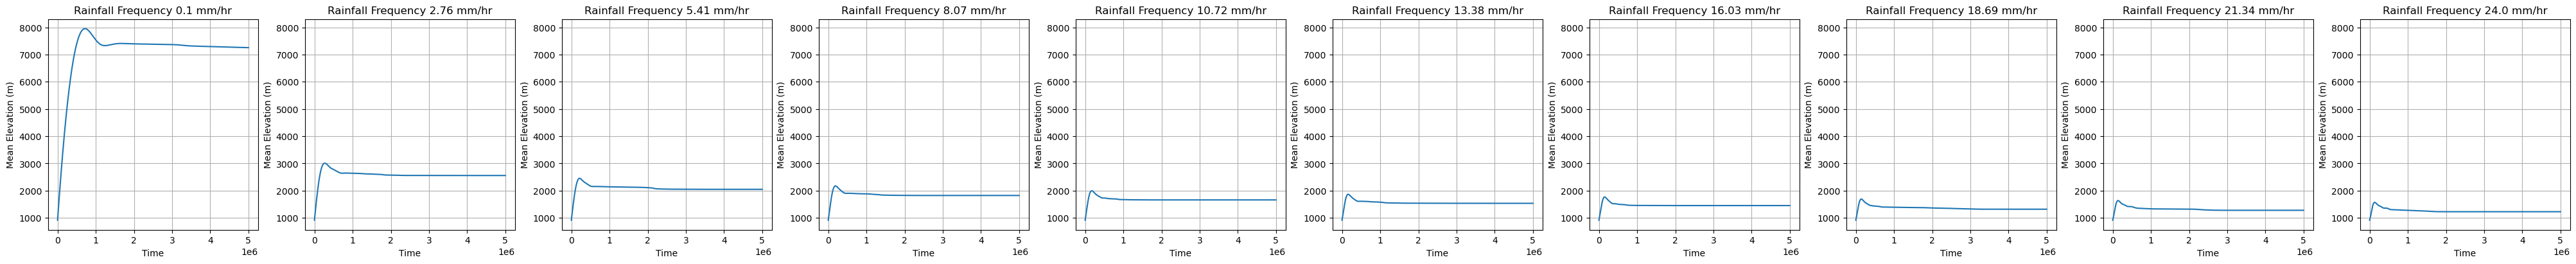

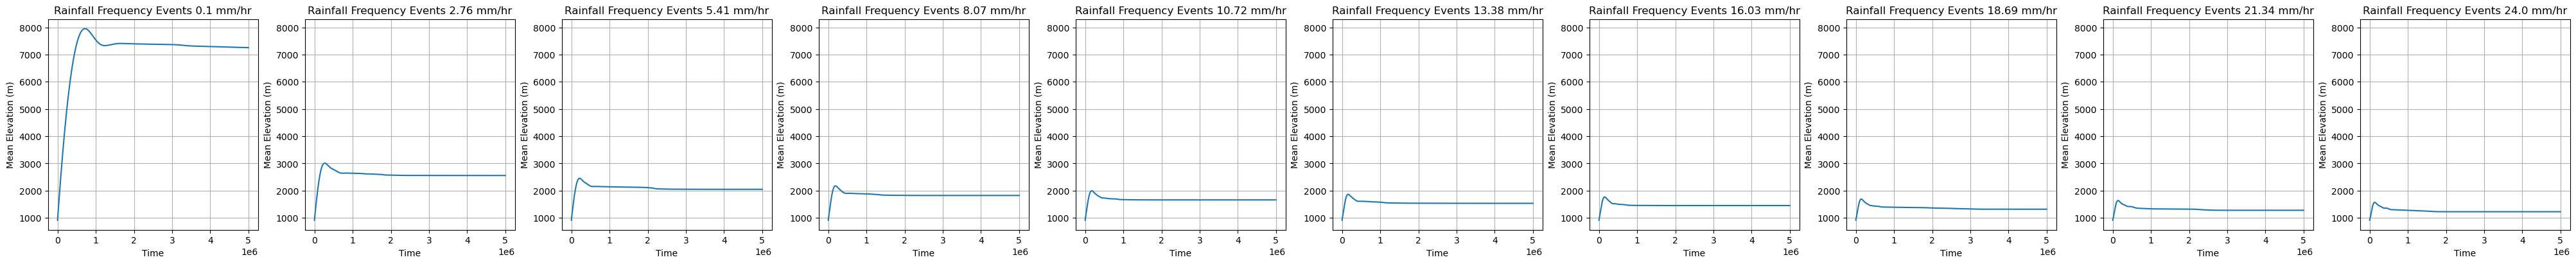

In [23]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and filter for rainfall_frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))

# Load datasets and compute mean elevations
datasets = []
rainfall_frequencies = []
mean_elevations = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract rainfall frequency from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    datasets.append(ds)
    rainfall_frequencies.append(rainfall_frequency)  # Correctly appending rainfall_frequency value
    mean_elevations.append(ds.topography__elevation.mean(dim=("x", "y")))  # Compute mean elevation

# If no valid datasets are found, raise an error
if not datasets:
    raise ValueError("No valid datasets found. Check the Zarr files in the directory.")

# Determine common y-axis limits with padding
y_min = min(elev.min().values for elev in mean_elevations)
y_max = max(elev.max().values for elev in mean_elevations)
padding = 0.05 * (y_max - y_min)  # Add 5% padding

y_min -= padding
y_max += padding

# Create mean elevation plots
num_rainfall_frequencies = len(rainfall_frequencies)
fig, axes = plt.subplots(nrows=1, ncols=num_rainfall_frequencies, figsize=(max(num_rainfall_frequencies * 4, 8), 4), constrained_layout=True)

# Ensure `axes` is always iterable (even for 1 subplot)
if num_rainfall_frequencies == 1:
    axes = [axes]

for ax, ds, rainfall_frequency, mean_elev in zip(axes, datasets, rainfall_frequencies, mean_elevations):
    ax.plot(ds.time, mean_elev, label=f"Rainfall Frequency Events {rainfall_frequency} mm/hr")
    ax.set_title(f"Rainfall Frequency Events {rainfall_frequency} mm/hr")
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Elevation (m)")
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits
    ax.grid()

# Save and show the figure
plt.savefig("Mean_Elevation_RainfallFrequency_Comparison.png")
plt.show()

# Close datasets
for ds in datasets:
    ds.close()


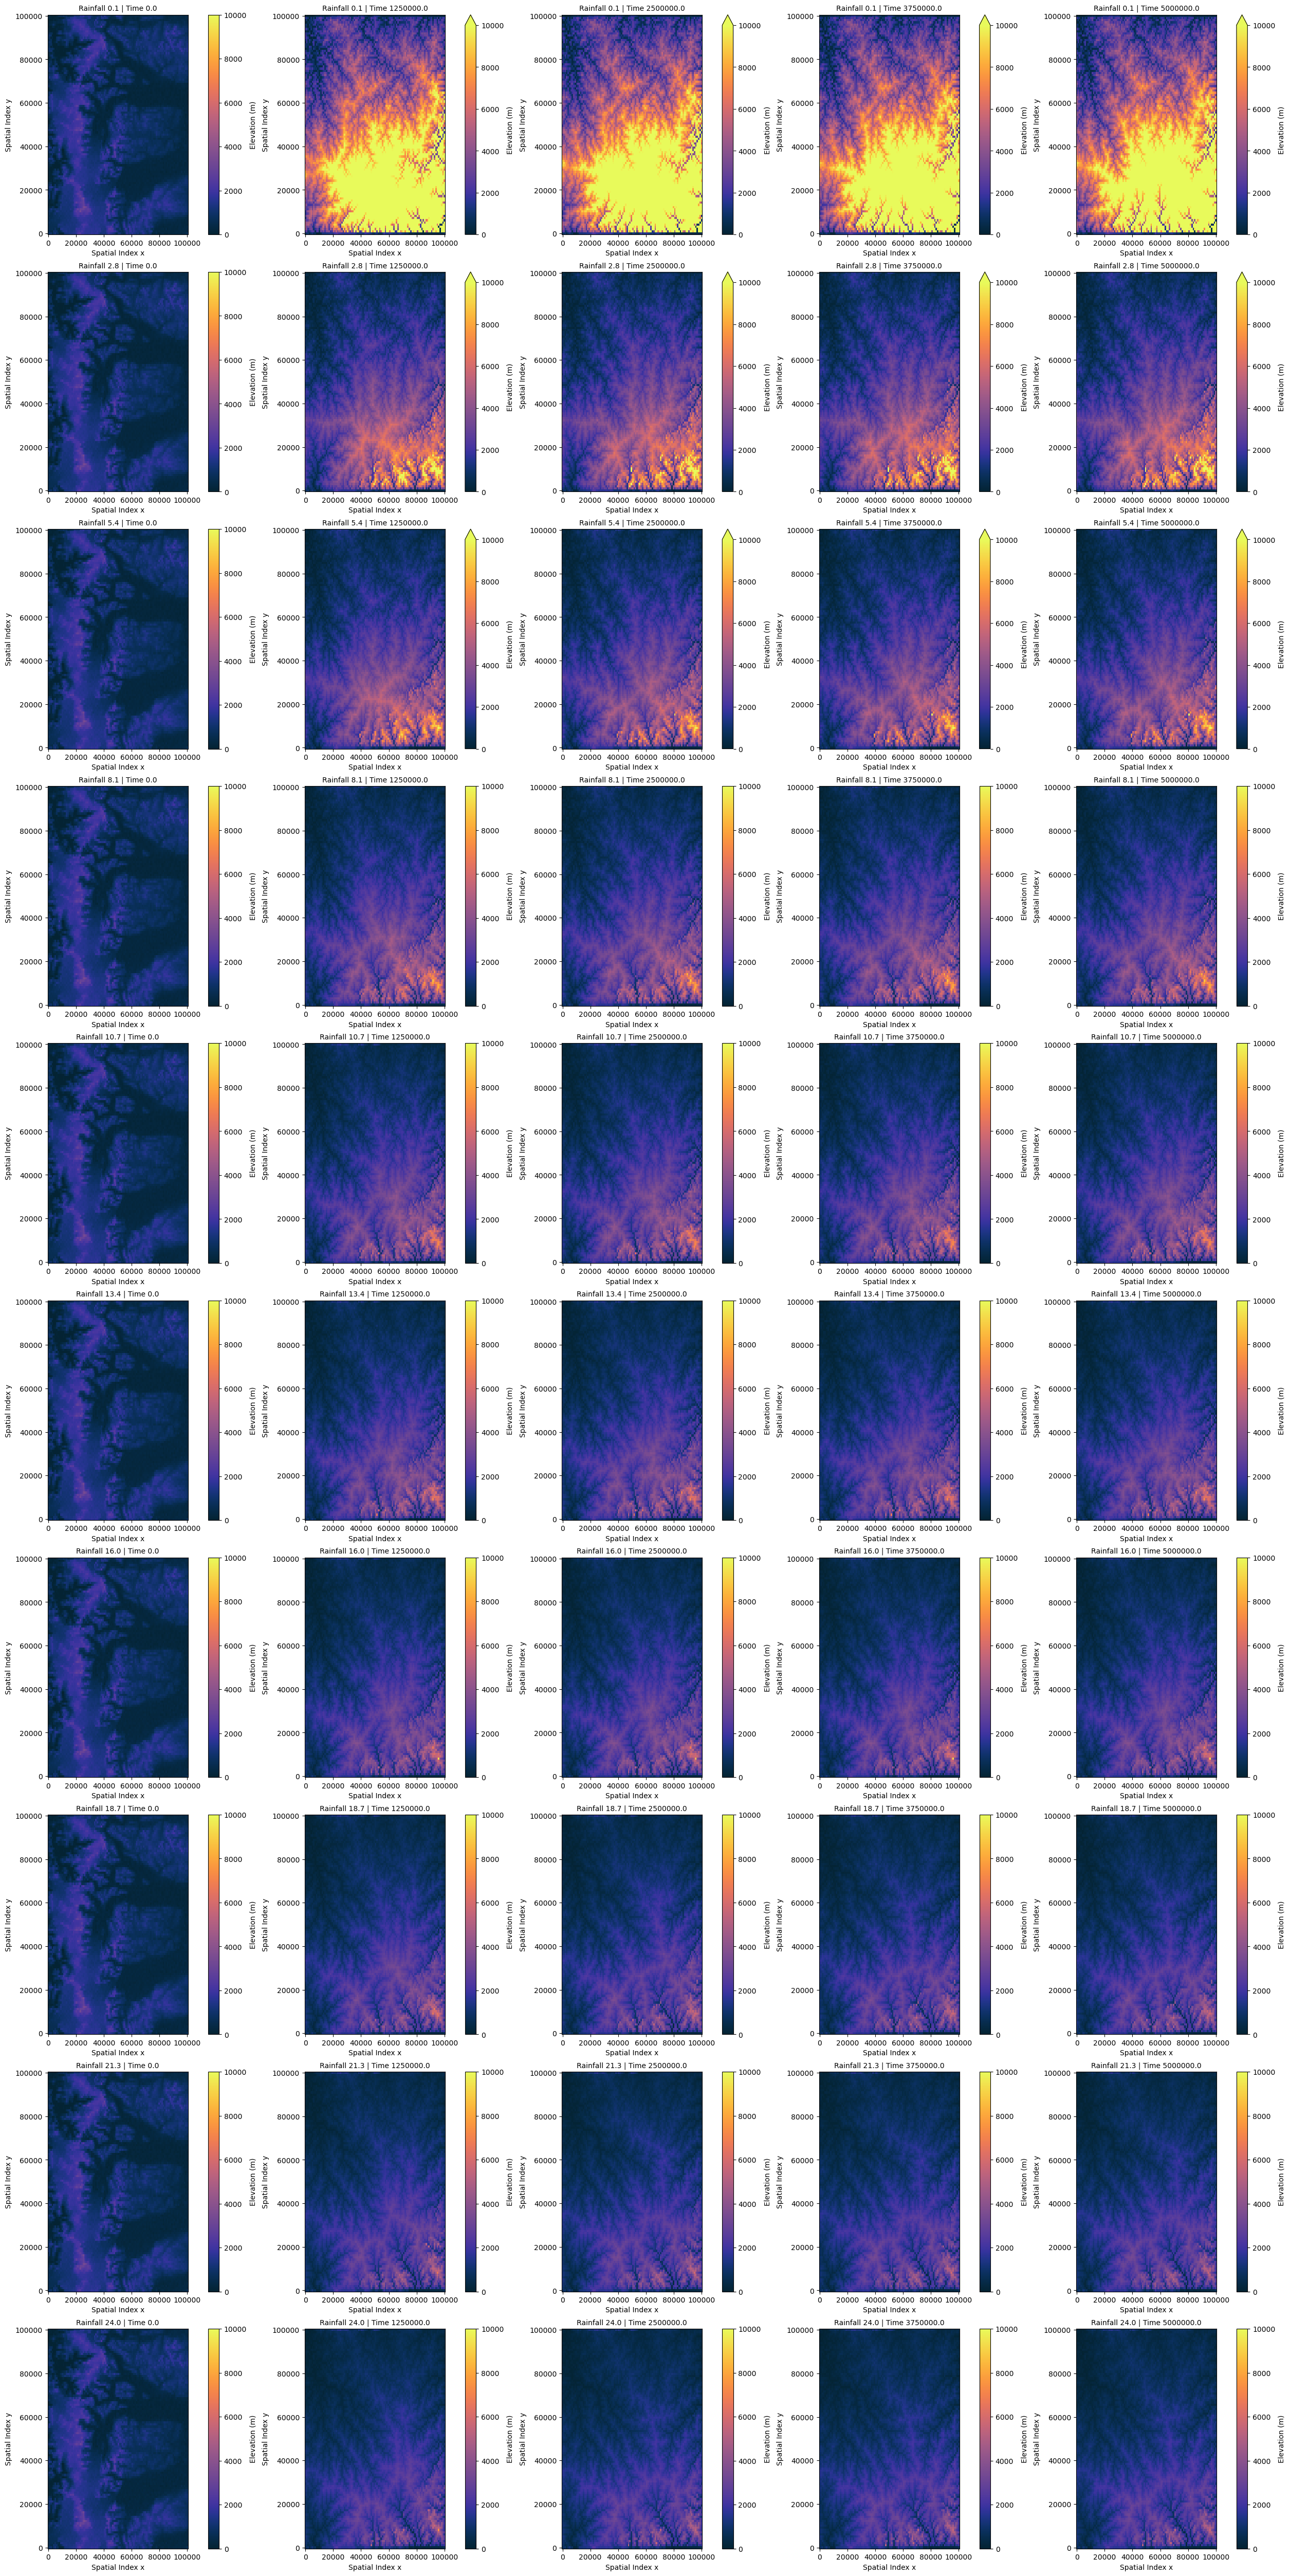

In [30]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean  # Improved colormap

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))

# Define the specific rainfall frequencies to plot
desired_rainfall_freqs = [0.1, 2.76, 5.41, 8.07, 10.72, 13.38, 16.03, 18.69, 21.34, 24.]

# Load datasets
datasets = []
rainfall_frequencies = []
for zarr_file in zarr_files:
    rainfall_freq = float(zarr_file.split("_")[-1][:-5])  # Extract rainfall frequency from filename
    if rainfall_freq in desired_rainfall_freqs:
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        ds = ds.assign_coords(rainfall_frequency=rainfall_freq)
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_freq)

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")

# Select time steps: First, last, and a few in between
time_indices = np.linspace(0, combined_ds.dims["time"] - 1, num=5, dtype=int)  # Adjust num=5 for more/less intervals

# Create plots
num_rainfall_freqs = len(rainfall_frequencies)
num_time_steps = len(time_indices)
fig, axes = plt.subplots(nrows=num_rainfall_freqs, ncols=num_time_steps, figsize=(num_time_steps * 5, num_rainfall_freqs * 5), constrained_layout=True)

# Loop over rainfall frequencies and time steps
for i, (ds, rainfall_freq) in enumerate(zip(datasets, rainfall_frequencies)):
    for j, t_idx in enumerate(time_indices):
        ax = axes[i, j]
        ds.topography__elevation.isel(time=t_idx).plot(ax=ax, vmin=0, vmax=10000, cmap=cmocean.cm.thermal, cbar_kwargs={"label": "Elevation (m)"})
        ax.set_title(f"Rainfall {rainfall_freq:.1f} | Time {ds.time.values[t_idx]:.1f}", fontsize=10)
        ax.set_xlabel("Spatial Index x")
        ax.set_ylabel("Spatial Index y")

# Save and show the figure
plt.savefig("Elevation_RainfallFrequency_TimeEvolution.png")
plt.show()

# Close datasets
for ds in datasets:
    ds.close()
